Do neighbouring states rate the beers more favourably or not compared to non neighbouring states?
Mapping the beer appreciation of geographically maybe? Eg for Californian beer, there is a concentration of enjoyment in California compared to other states.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [29]:
#needs changing but US ratings of beers with user_state and beer_state

BA_merged = pd.read_csv('../../minimizedData/BA_ratings_small_plus.csv')
US_ratings = BA_merged.dropna(subset=['beer_location','user_location','rating'])
US_ratings = US_ratings[US_ratings['user_location'].str.startswith('United States,')]
US_ratings = US_ratings[US_ratings['beer_location'].str.startswith('United States,')]

US_ratings['user_state'] = US_ratings['user_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings['beer_state'] = US_ratings['beer_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings = US_ratings.drop(['user_location','beer_location'], axis=1)

US_ratings = US_ratings[(US_ratings['user_state'] != 'United States') & (US_ratings['beer_state'] != 'United States')]

US_ratings.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,avg,user_state,beer_state
1008809,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,n2185.211743,2.50,4.00,4.00,3.75,3.75,3.76,3.76,North Carolina,Wisconsin
1008810,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,n2185.211743,3.00,3.75,4.00,3.50,3.50,3.58,3.58,North Carolina,Wisconsin
1008811,One Cent Wheat,289319.0,Copper State Brewing Company,49595.0,Witbier,n2185.211743,3.75,3.25,3.75,3.50,3.50,3.48,3.48,North Carolina,Wisconsin


In [30]:
US_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6331638 entries, 1008809 to 8393031
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   beer_name     object 
 1   beer_id       float64
 2   brewery_name  object 
 3   brewery_id    float64
 4   style         object 
 5   user_id       object 
 6   appearance    float64
 7   aroma         float64
 8   palate        float64
 9   taste         float64
 10  overall       float64
 11  rating        float64
 12  avg           float64
 13  user_state    object 
 14  beer_state    object 
dtypes: float64(9), object(6)
memory usage: 772.9+ MB


In [31]:
#csv file containing all the states and their neighbouring states
#empty list for states that have no neighbours (e.g Alazka, Hawaii)
neighbours_df = pd.read_csv('../../additionalData/bordering_states.csv', dtype={'state':'string', 
                                                                          'neighbours': 'string'})
neighbours_df["neighbours"] = neighbours_df["neighbours"].fillna("").apply(lambda x: x.split(";") if x else [])

neighbours_df.head(3)

,state,neighbours,nb_neighbours
0,Alabama,"[Florida, Georgia, Mississippi, Tennessee]",4
1,Alaska,[],0
2,Arizona,"[California, Colorado, Nevada, New Mexico, Utah]",5


In [32]:
neighbours_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state          50 non-null     string
 1   neighbours     50 non-null     object
 2   nb_neighbours  50 non-null     int64 
dtypes: int64(1), object(1), string(1)
memory usage: 1.3+ KB


In [33]:
neighbours = neighbours_df.loc[neighbours_df['state'] == 'Texas', 'neighbours'].values[0]
print(neighbours)

['Arkansas', 'Louisiana', 'New Mexico', 'Oklahoma']


In [57]:
def gather_state_ratings(state, US_ratings, neighbours_df):
    # Get the neighbors for the given state
    neighbours = neighbours_df.loc[neighbours_df['state'] == state, 'neighbours'].values[0]
    
    # All US_ratings for beers from the state of interest
    state_ratings = US_ratings[US_ratings['beer_state'] == state]
    
    # Collect US_ratings by group
    in_state_ratings = state_ratings[state_ratings['user_state'] == state]['rating'].tolist()
    neighbours_ratings = state_ratings[state_ratings['user_state'].isin(neighbours)]['rating'].tolist()
    non_neighbours_ratings = state_ratings[~state_ratings['user_state'].isin(neighbours) & 
                                           (state_ratings['user_state'] != state)]['rating'].tolist()
    
    return in_state_ratings, neighbours_ratings, non_neighbours_ratings

# List of all states
states = US_ratings['beer_state'].unique()

# Store all US_ratings in a list for each group
all_ratings = {'state': [], 'rating': [], 'rating_type': []}

# Loop through each state and gather individual US_ratings
for state in states:
    in_state, neighbours, non_neighbours = gather_state_ratings(state, US_ratings, neighbours_df)
    
    # Add to the combined dictionary
    all_ratings['state'].extend([state] * (len(in_state) + len(neighbours) + len(non_neighbours)))
    all_ratings['rating'].extend(in_state + neighbours + non_neighbours)
    all_ratings['rating_type'].extend(['In-State'] * len(in_state) + 
                                      ['Neighbours'] * len(neighbours) + 
                                      ['Non-Neighbours'] * len(non_neighbours))

# Convert results to a DataFrame suitable for plotting
ratings_df = pd.DataFrame(all_ratings)

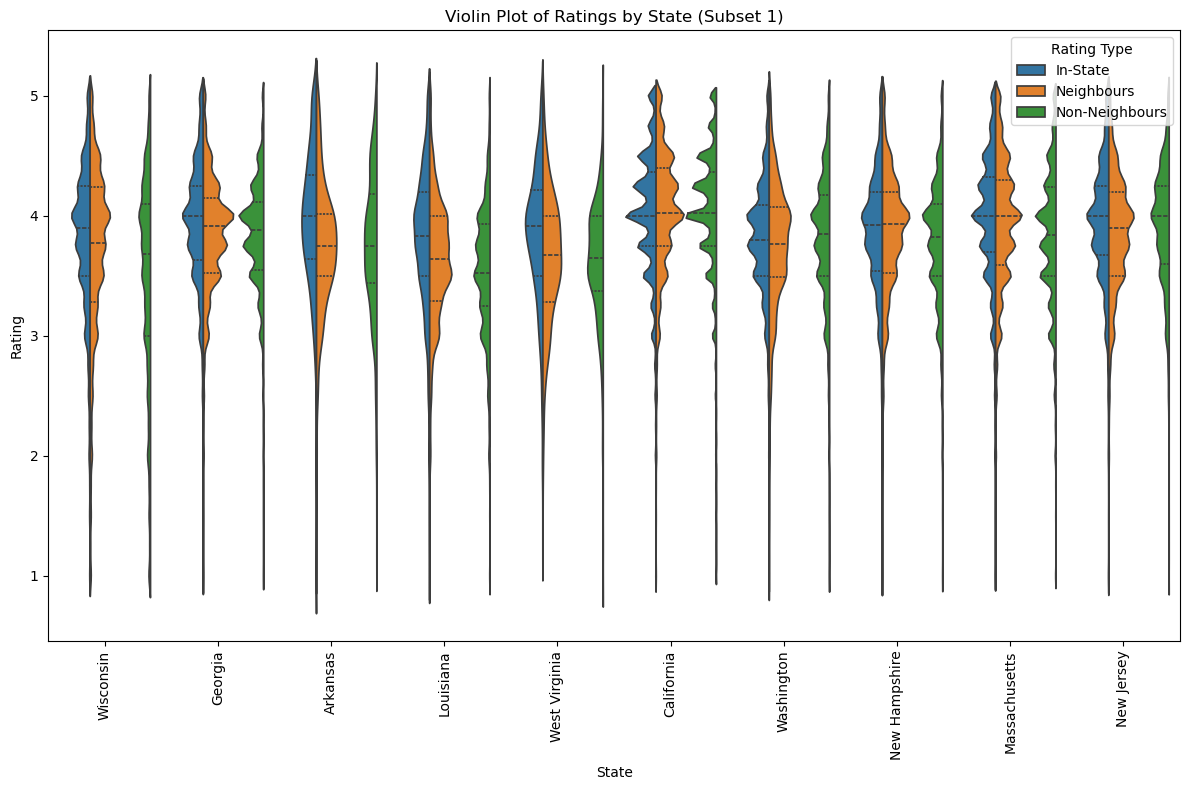

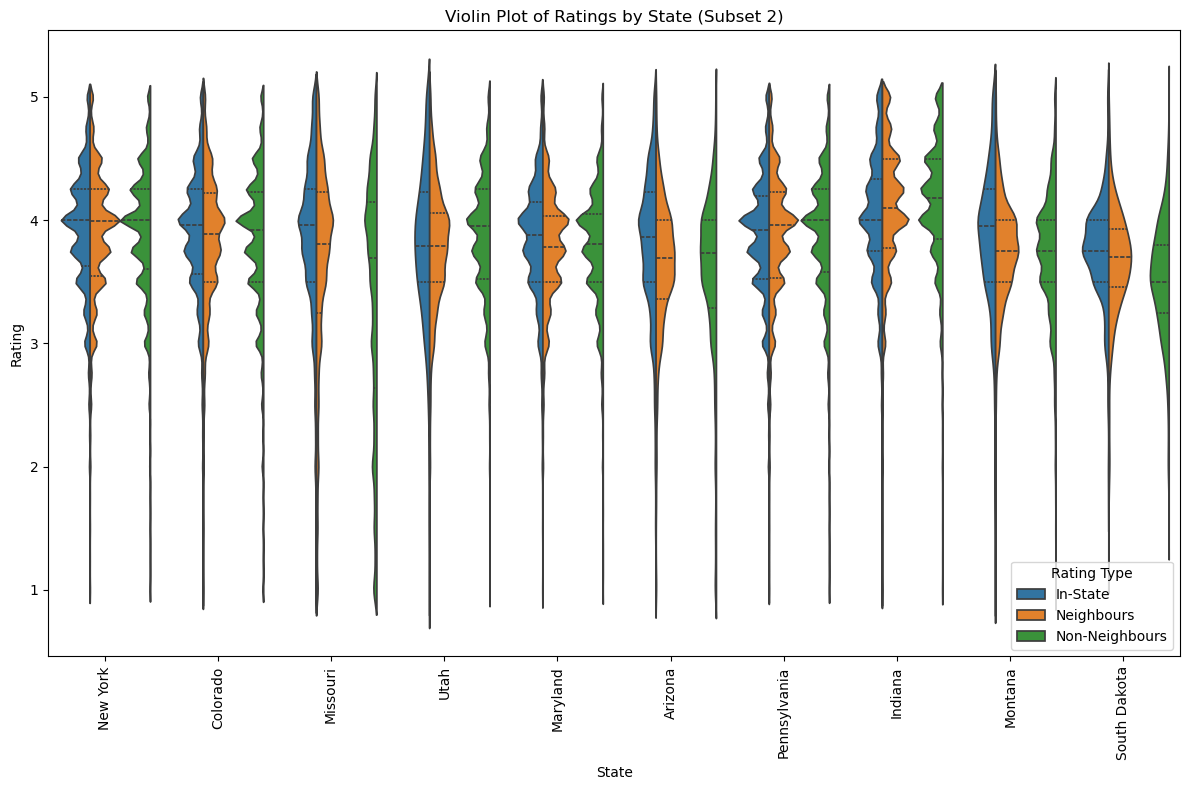

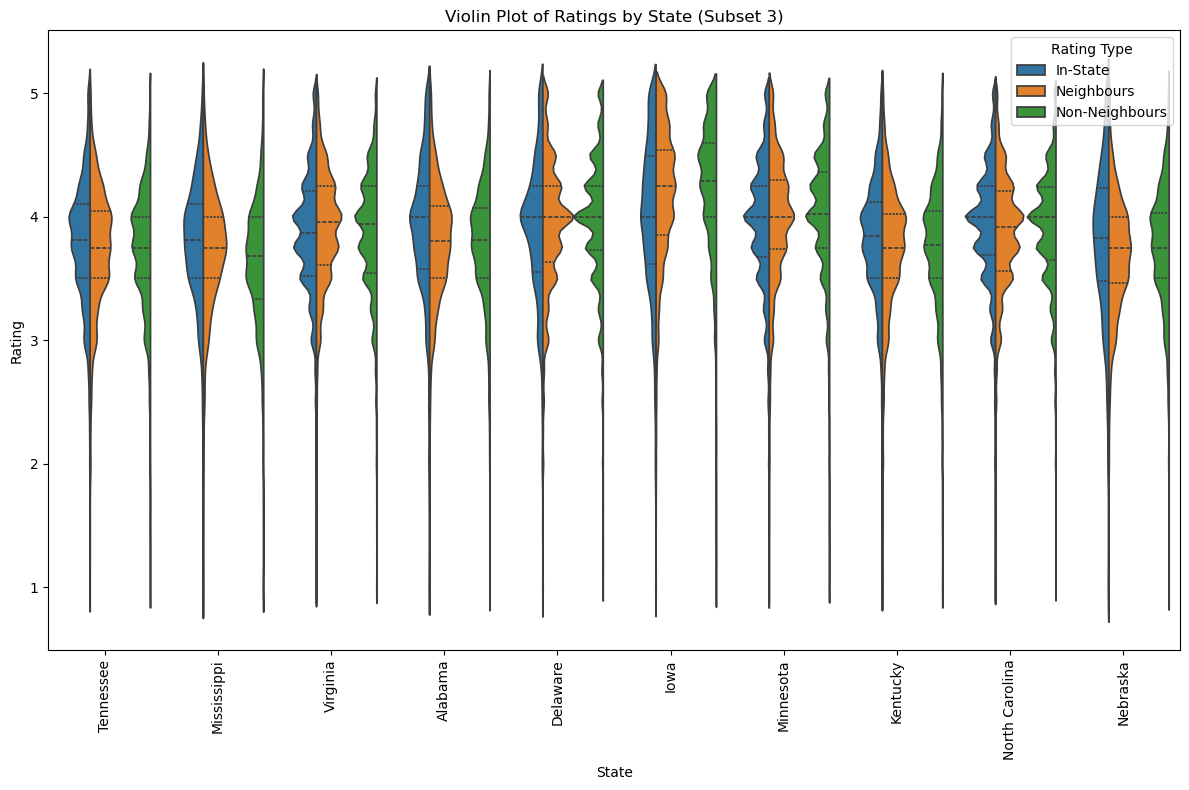

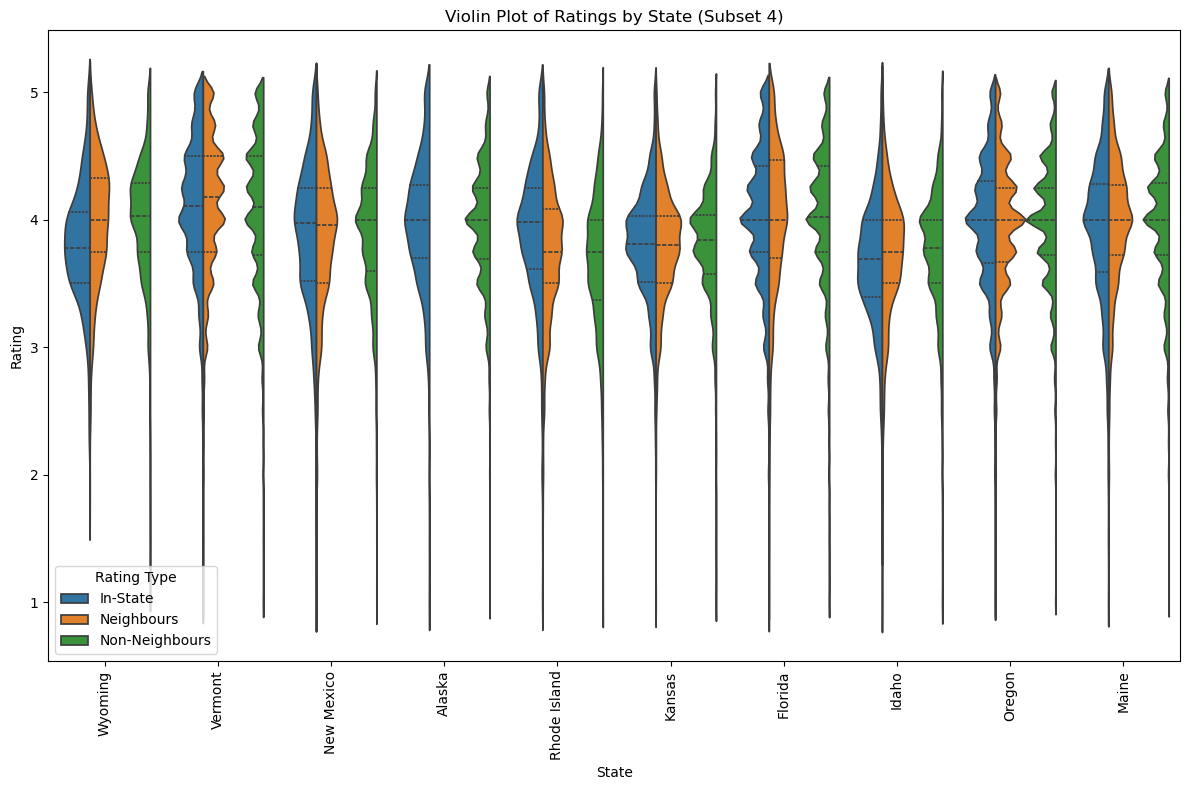

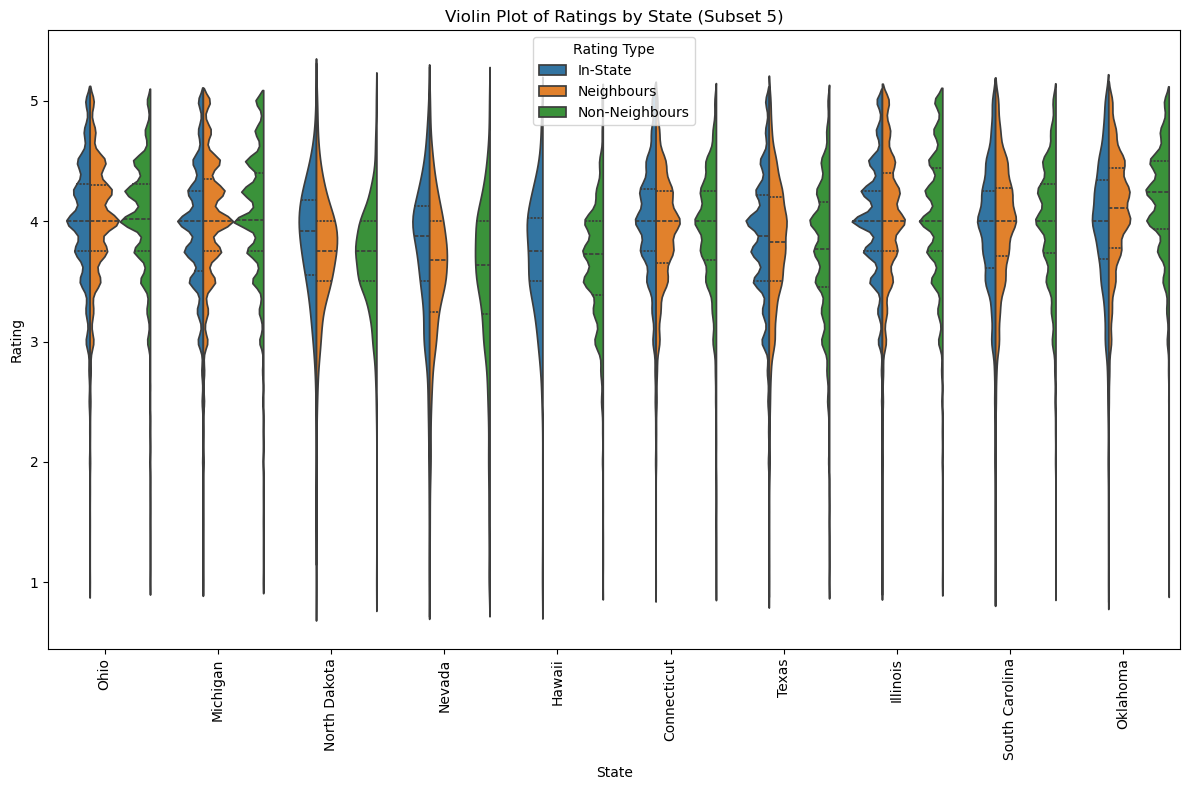

In [35]:
# Define the number of states to display per figure
states_per_fig = 10

# Get unique states and calculate number of figures needed
unique_states = US_ratings['beer_state'].unique()
num_figures = math.ceil(len(unique_states) / states_per_fig)

# Loop through in chunks and plot
for i in range(num_figures):
    # Define the subset of states for this figure
    states_subset = unique_states[i * states_per_fig : (i + 1) * states_per_fig]
    subset_data = ratings_df[ratings_df['state'].isin(states_subset)]
    
    # Create the violin plot for this subset
    plt.figure(figsize=(12, 8))
    sns.violinplot(
        x='state', 
        y='rating', 
        hue='rating_type', 
        data=subset_data, 
        split=True, 
        inner='quartile'
    )
    
    # Add plot details
    plt.title(f"Violin Plot of Ratings by State (Subset {i+1})")
    plt.xlabel("State")
    plt.ylabel("Rating")
    plt.xticks(rotation=90)
    plt.legend(title="Rating Type")
    plt.tight_layout()
    plt.show()


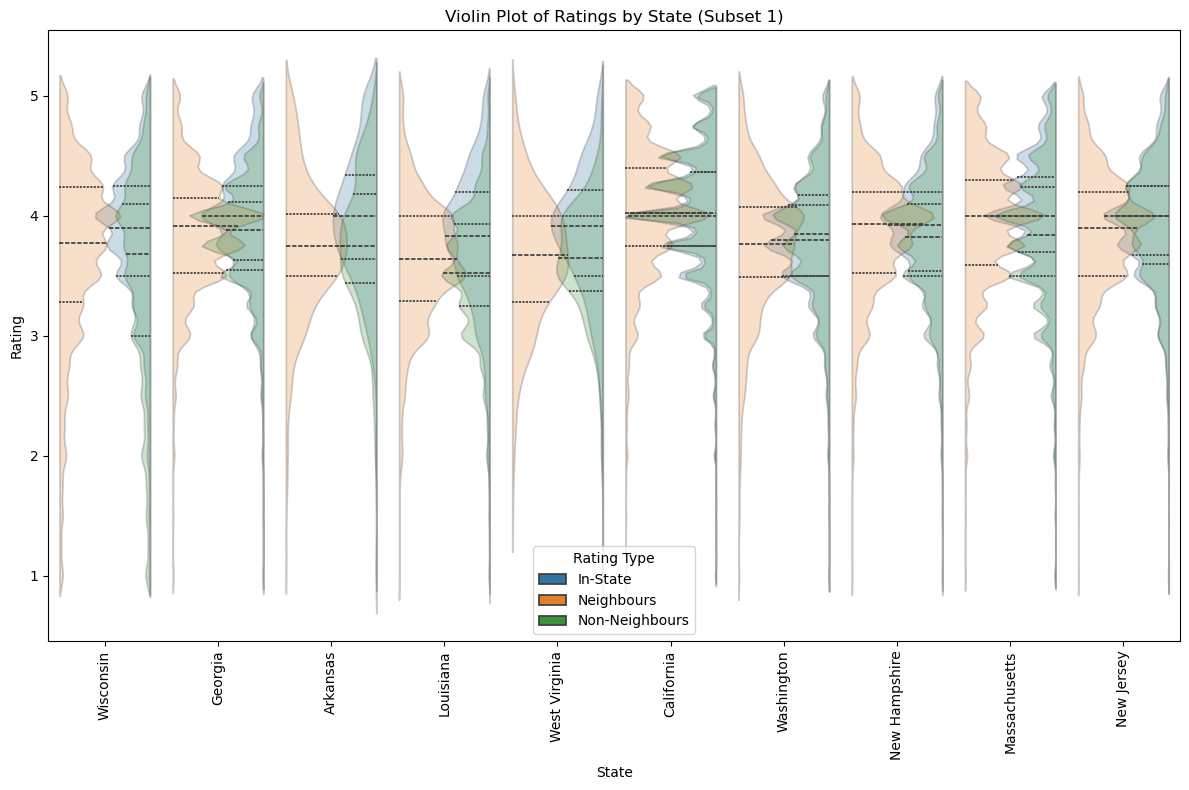

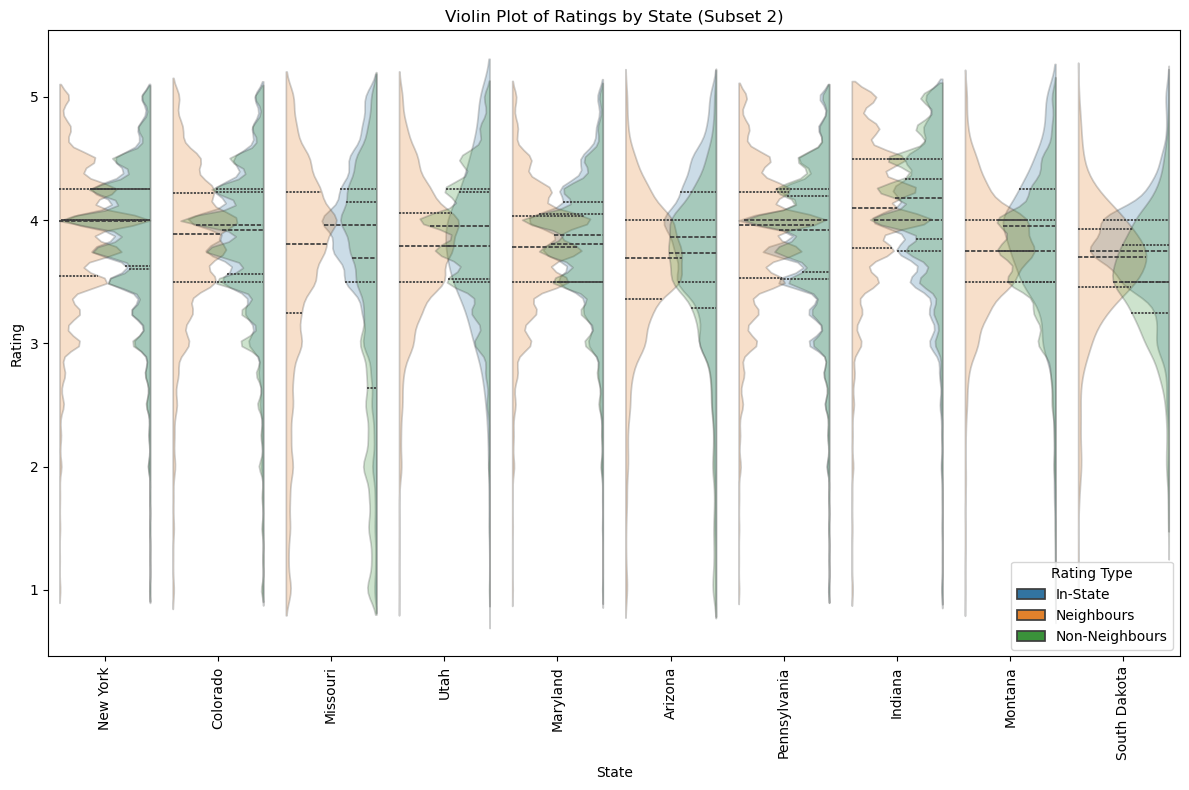

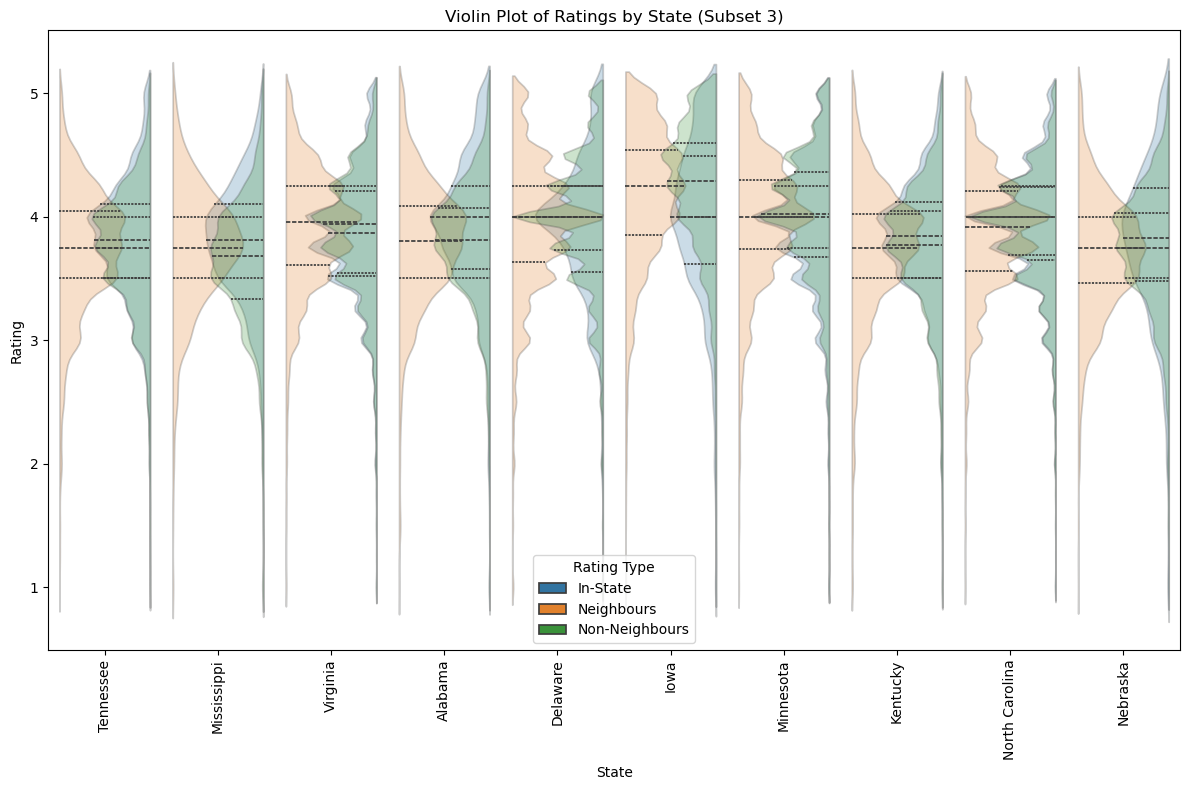

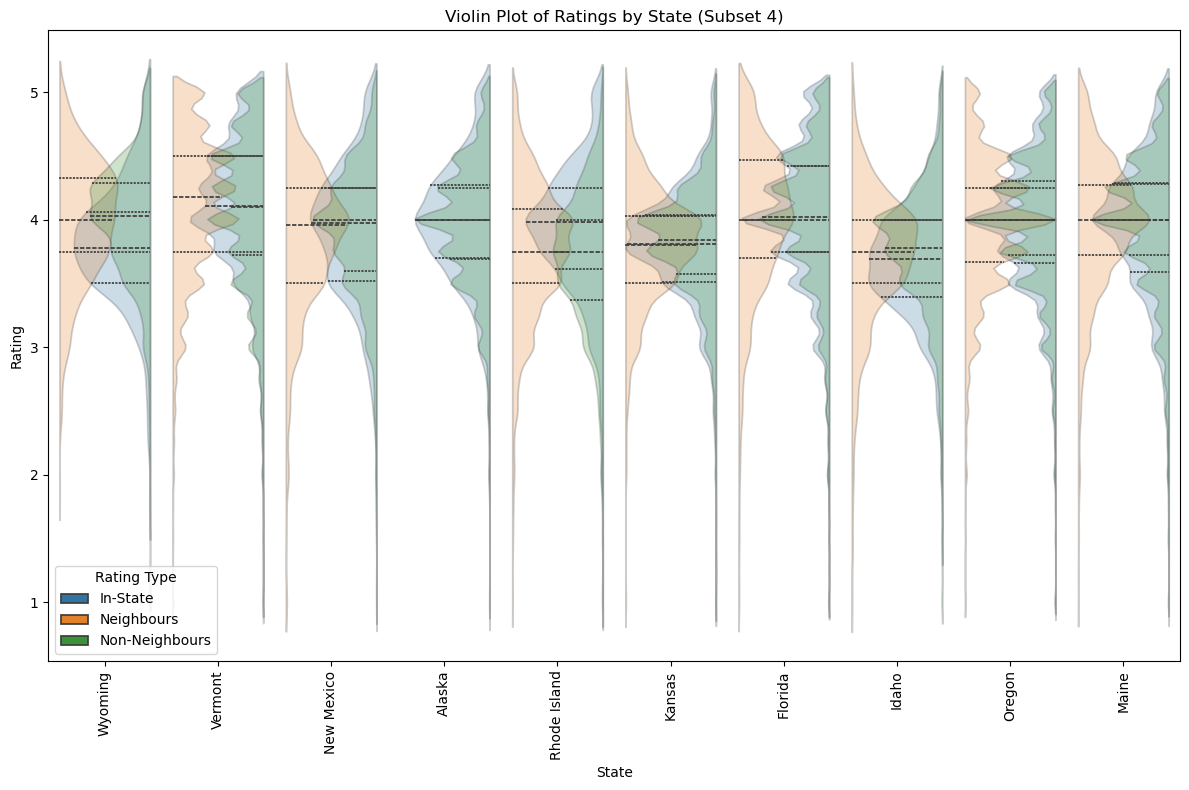

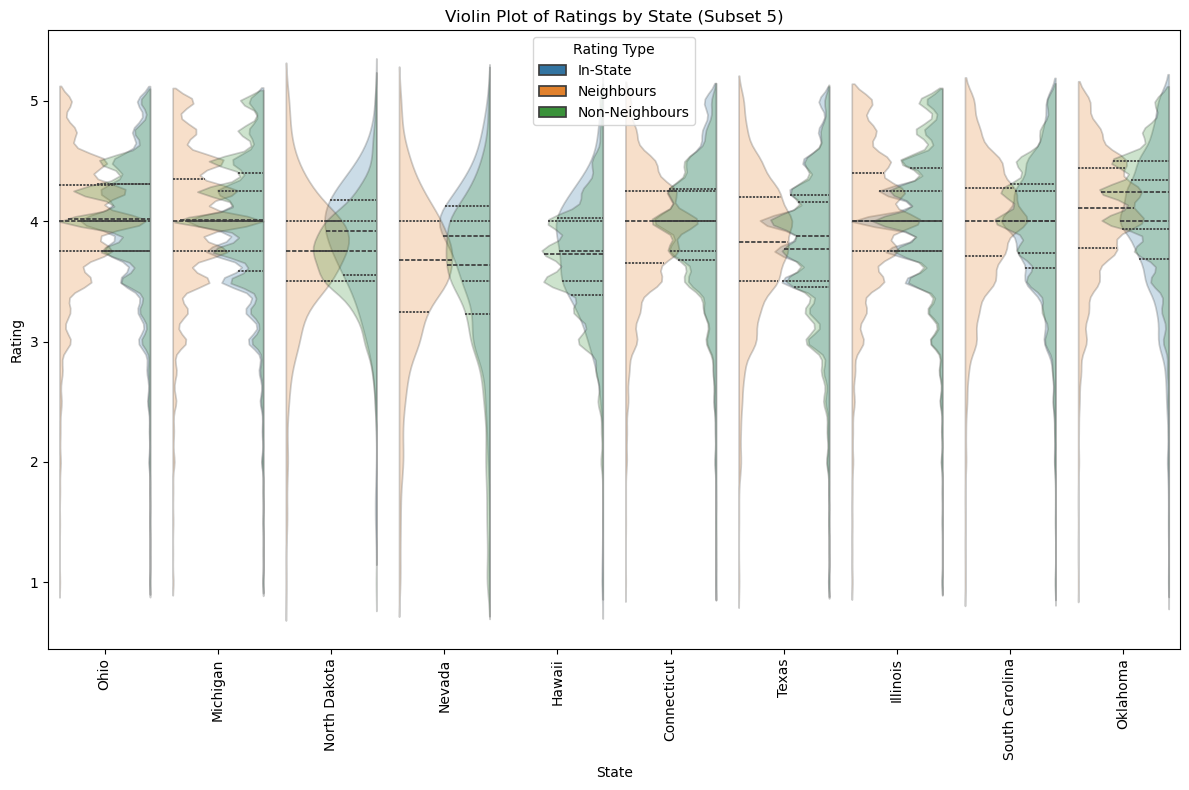

In [69]:
# Loop through in chunks and plot
for i in range(num_figures):
    # Define the subset of states for this figure
    states_subset = unique_states[i * states_per_fig : (i + 1) * states_per_fig]
    subset_data = ratings_df[ratings_df['state'].isin(states_subset)]

    # Create the violin plot for this subset
    plt.figure(figsize=(12, 8))
    
    # Plot In-State vs Neighbours and Non-Neighbours without splitting them
    ax = sns.violinplot(
        x='state', 
        y='rating', 
        hue='rating_type', 
        data=subset_data, 
        inner='quartile',
        split=True,
        dodge=False  # Ensure they are side-by-side but on the same axis
    )
    
    # Adjust transparency of the violins
    for collection in ax.collections:
        collection.set_alpha(0.25)  # Set transparency (0 = fully transparent, 1 = opaque)

    # Add plot details
    plt.title(f"Violin Plot of Ratings by State (Subset {i+1})")
    plt.xlabel("State")
    plt.ylabel("Rating")
    plt.xticks(rotation=90)
    plt.legend(title="Rating Type")
    plt.tight_layout()
    plt.show()


In [37]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

In [38]:
# Initialize dictionary to store Cohen's d results
cohen_results = {
    'state': [],
    'd_in_vs_neigh': [],
    'd_in_vs_non_neigh': []
}

# Loop over each state and calculate Cohen's d for different rating comparisons
for state in ratings_df['state'].unique():
    subset = ratings_df[ratings_df['state'] == state]
    in_state_ratings = subset[subset['rating_type'] == 'In-State']['rating']
    neighbours_ratings = subset[subset['rating_type'] == 'Neighbours']['rating']
    non_neighbours_ratings = subset[subset['rating_type'] == 'Non-Neighbours']['rating']
    
    # Calculate Cohen's d values, handling cases with missing data
    d_in_vs_neigh = cohen_d(in_state_ratings, neighbours_ratings) if len(in_state_ratings) > 0 and len(neighbours_ratings) > 0 else np.nan
    d_in_vs_non_neigh = cohen_d(in_state_ratings, non_neighbours_ratings) if len(in_state_ratings) > 0 and len(non_neighbours_ratings) > 0 else np.nan

    # Append results for each state
    cohen_results['state'].append(state)
    cohen_results['d_in_vs_neigh'].append(d_in_vs_neigh)
    cohen_results['d_in_vs_non_neigh'].append(d_in_vs_non_neigh)

# Convert results to DataFrame
cohen_df = pd.DataFrame(cohen_results)


In [39]:
alphabetical_cohen = cohen_df.sort_values(by='state', ascending=True, )

alphabetical_cohen.reset_index(drop=True, inplace=True)


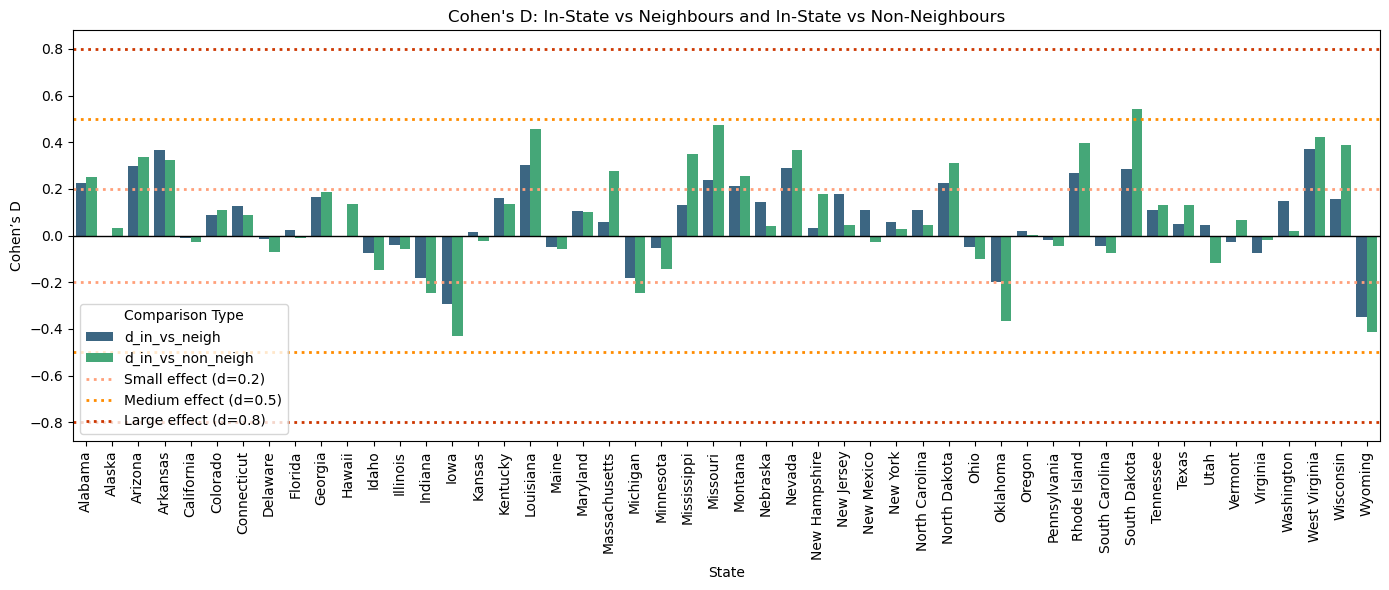

In [70]:
# Combining both Cohen's D values in one DataFrame
alphabetical_cohen_melted = alphabetical_cohen.melt(id_vars='state', value_vars=['d_in_vs_neigh', 'd_in_vs_non_neigh'], 
                                                    var_name='comparison', value_name='cohen_d')

# Plotting Cohen's D side by side for each state
plt.figure(figsize=(14, 6))
sns.barplot(x='state', y='cohen_d', hue='comparison', data=alphabetical_cohen_melted, palette='viridis')

# Add plot details
plt.title("Cohen's D: In-State vs Neighbours and In-State vs Non-Neighbours")
plt.axhline(0, color='black', linewidth=1)
plt.axhline(0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(-0.8, color='#CD3700', linestyle=':', linewidth=2)
plt.xlabel("State")
plt.ylabel("Cohen’s D")
plt.xticks(rotation=90)
plt.legend(title="Comparison Type")
plt.tight_layout()
plt.show()

In [42]:
neighbours_cohen = cohen_df.sort_values(by='d_in_vs_neigh', ascending=True, )

neighbours_cohen.reset_index(drop=True, inplace=True)


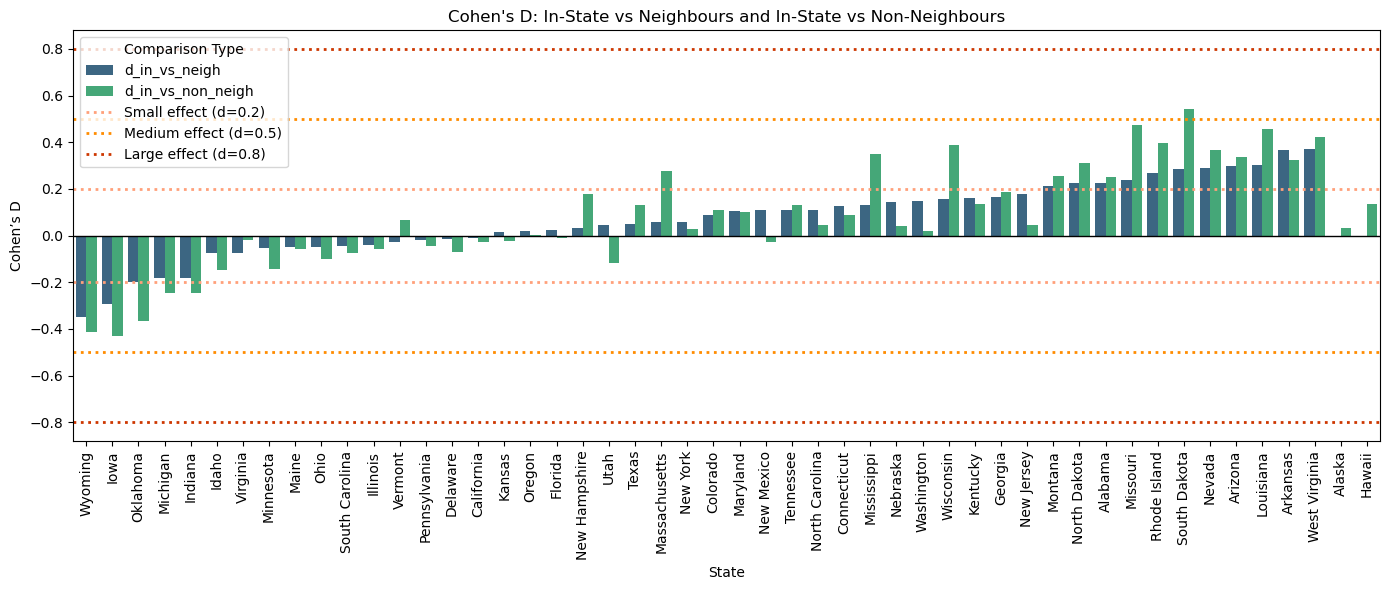

In [71]:
# Combining both Cohen's D values in one DataFrame
neighbours_cohen_melted = neighbours_cohen.melt(id_vars='state', value_vars=['d_in_vs_neigh', 'd_in_vs_non_neigh'], 
                                                    var_name='comparison', value_name='cohen_d')

# Plotting Cohen's D side by side for each state
plt.figure(figsize=(14, 6))
sns.barplot(x='state', y='cohen_d', hue='comparison', data=neighbours_cohen_melted, palette='viridis')

# Add plot details
plt.title("Cohen's D: In-State vs Neighbours and In-State vs Non-Neighbours")
plt.axhline(0, color='black', linewidth=1)
plt.axhline(0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(-0.8, color='#CD3700', linestyle=':', linewidth=2)
plt.xlabel("State")
plt.ylabel("Cohen’s D")
plt.xticks(rotation=90)
plt.legend(title="Comparison Type")
plt.tight_layout()
plt.show()

In [44]:
nonneighbours_cohen = cohen_df.sort_values(by='d_in_vs_non_neigh', ascending=True, )

nonneighbours_cohen.reset_index(drop=True, inplace=True)


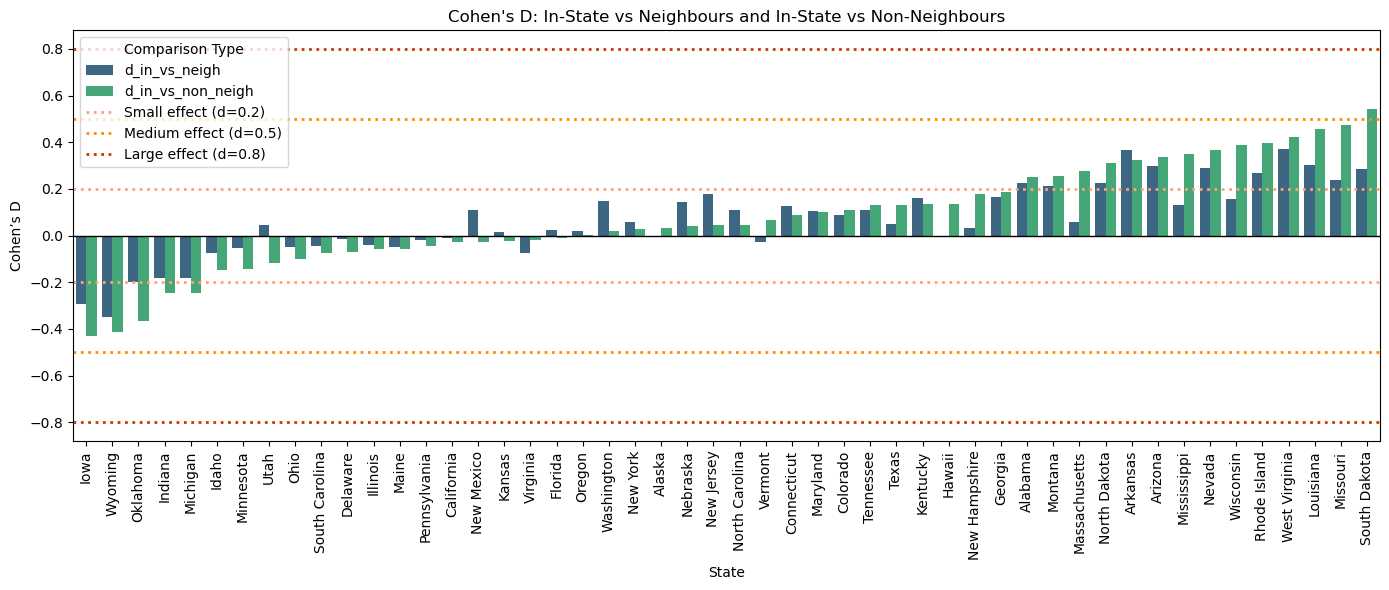

In [72]:
# Combining both Cohen's D values in one DataFrame
nonneighbours_cohen_melted = nonneighbours_cohen.melt(id_vars='state', value_vars=['d_in_vs_neigh', 'd_in_vs_non_neigh'], 
                                                    var_name='comparison', value_name='cohen_d')

# Plotting Cohen's D side by side for each state
plt.figure(figsize=(14, 6))
sns.barplot(x='state', y='cohen_d', hue='comparison', data=nonneighbours_cohen_melted, palette='viridis')

# Add plot details
plt.title("Cohen's D: In-State vs Neighbours and In-State vs Non-Neighbours")
plt.axhline(0, color='black', linewidth=1)
plt.axhline(0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(-0.8, color='#CD3700', linestyle=':', linewidth=2)
plt.xlabel("State")
plt.ylabel("Cohen’s D")
plt.xticks(rotation=90)
plt.legend(title="Comparison Type")
plt.tight_layout()
plt.show()

In [46]:
# Calculate and return the average ratings for in state, its neighbours, and non-neighbors
def calculate_state_ratings(state, ratings, neighbours_df):
    # Get the neighbours for the given state
    neighbours = neighbours_df.loc[neighbours_df['state'] == state, 'neighbours'].values[0]
    
    # Get all ratings for the beers from the state of interest
    state_ratings = ratings[ratings['beer_state'] == state]
    
    # Ratings for in state, neighbours and non-neighbours
    in_state_ratings = state_ratings[state_ratings['user_state'] == state]['rating']
    neighbours_ratings = state_ratings[state_ratings['user_state'].isin(neighbours)]['rating']
    non_neighbours_ratings = state_ratings[~state_ratings['user_state'].isin(neighbours) & (state_ratings['user_state'] != state)]['rating']
    
    # Calculate the average ratings while considering the fact there may not be any states present and average is None
    state_avg = state_ratings['rating'].mean() if not state_ratings.empty else None  # Calculate the state's average rating for all beers
    neighbours_avg = neighbours_ratings.mean() if not neighbours_ratings.empty else None
    non_neighbours_avg = non_neighbours_ratings.mean() if not non_neighbours_ratings.empty else None
    
    return state_avg, neighbours_avg, non_neighbours_avg

# List of all states
states = US_ratings['user_state'].unique()

# Store results
ratings_results = []

# Loop through all states and calculate average ratings using function above
# Creating dictionary with all averages
for state in states:
    print(state)
    state_avg, neighbours_avg, non_neighbours_avg = calculate_state_ratings(state, US_ratings, neighbours_df)
    ratings_results.append({
        'state': state,
        'state_avg': state_avg,
        'neighbours_avg': neighbours_avg,
        'non_neighbours_avg': non_neighbours_avg
    })

# Convert results to DataFrame
ratings_df = pd.DataFrame(ratings_results)

# Print the results (just showing the first 3 rows)
print(ratings_df.head(3))


North Carolina
Wisconsin
Illinois
New York
Missouri
Pennsylvania
Michigan
Oklahoma
Arizona
California
Maryland
Florida
Virginia
Georgia
Washington
Iowa
Minnesota
New Jersey
Oregon
South Carolina
Texas
Massachusetts
Colorado
Indiana
Alaska
Idaho
Ohio
Nebraska
Tennessee
Nevada
Kansas
Louisiana
South Dakota
New Hampshire
Connecticut
Mississippi
West Virginia
Delaware
Maine
Vermont
Rhode Island
Kentucky
Arkansas
Wyoming
Alabama
New Mexico
North Dakota
Montana
Utah
Hawaii
            state  state_avg  neighbours_avg  non_neighbours_avg
0  North Carolina   3.898341        3.863558            3.896244
1       Wisconsin   3.600401        3.680441            3.472127
2        Illinois   4.009972        4.012173            4.024161


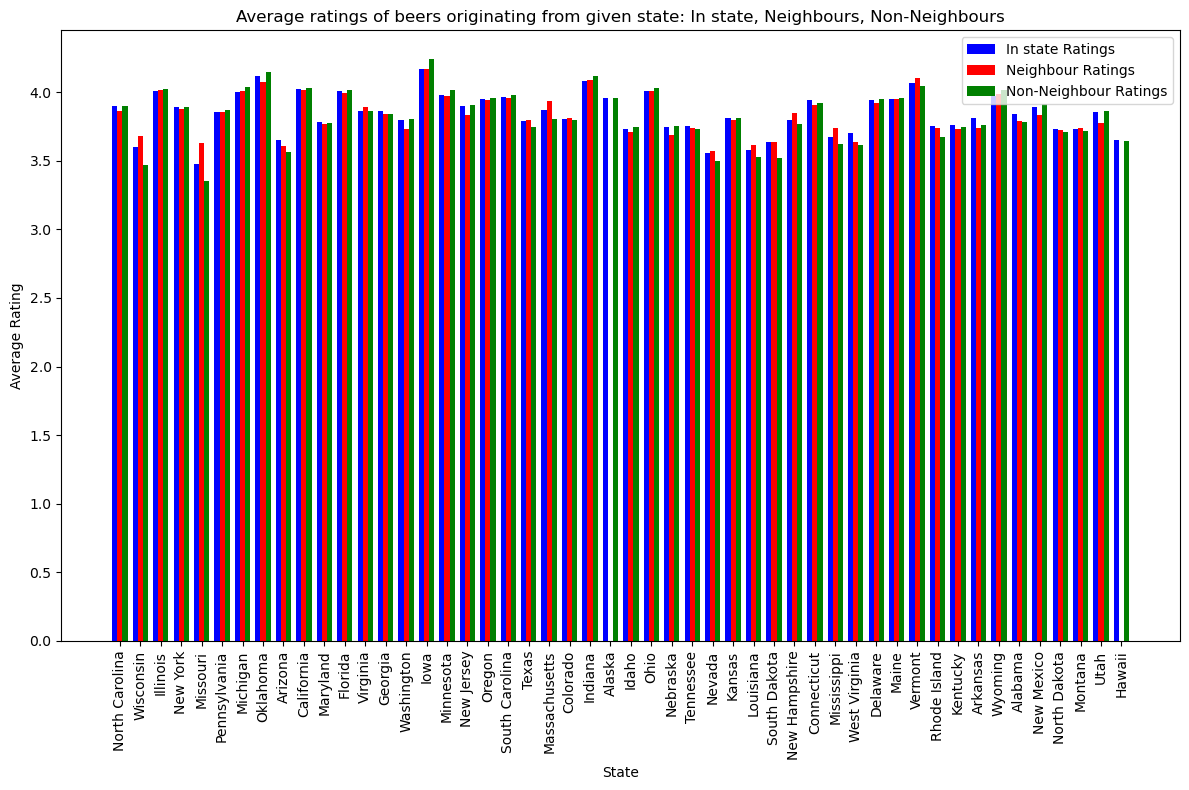

In [47]:
plt.figure(figsize=(12, 8))

bar = 0.25
index = np.arange(len(ratings_df))

#placing bars for each location of ratings next to each other
plt.bar(index, ratings_df['state_avg'], bar, label='In state Ratings', color='blue')
plt.bar(index + bar, ratings_df['neighbours_avg'], bar, label='Neighbour Ratings', color='red')
plt.bar(index + 2 * bar, ratings_df['non_neighbours_avg'], bar, label='Non-Neighbour Ratings', color='green')
plt.xticks(index + bar, ratings_df['state'], rotation=90)
plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Average ratings of beers originating from given state: In state, Neighbours, Non-Neighbours')
plt.legend()
plt.tight_layout()
plt.show()


In [48]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               50 non-null     object 
 1   state_avg           50 non-null     float64
 2   neighbours_avg      48 non-null     float64
 3   non_neighbours_avg  50 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.7+ KB


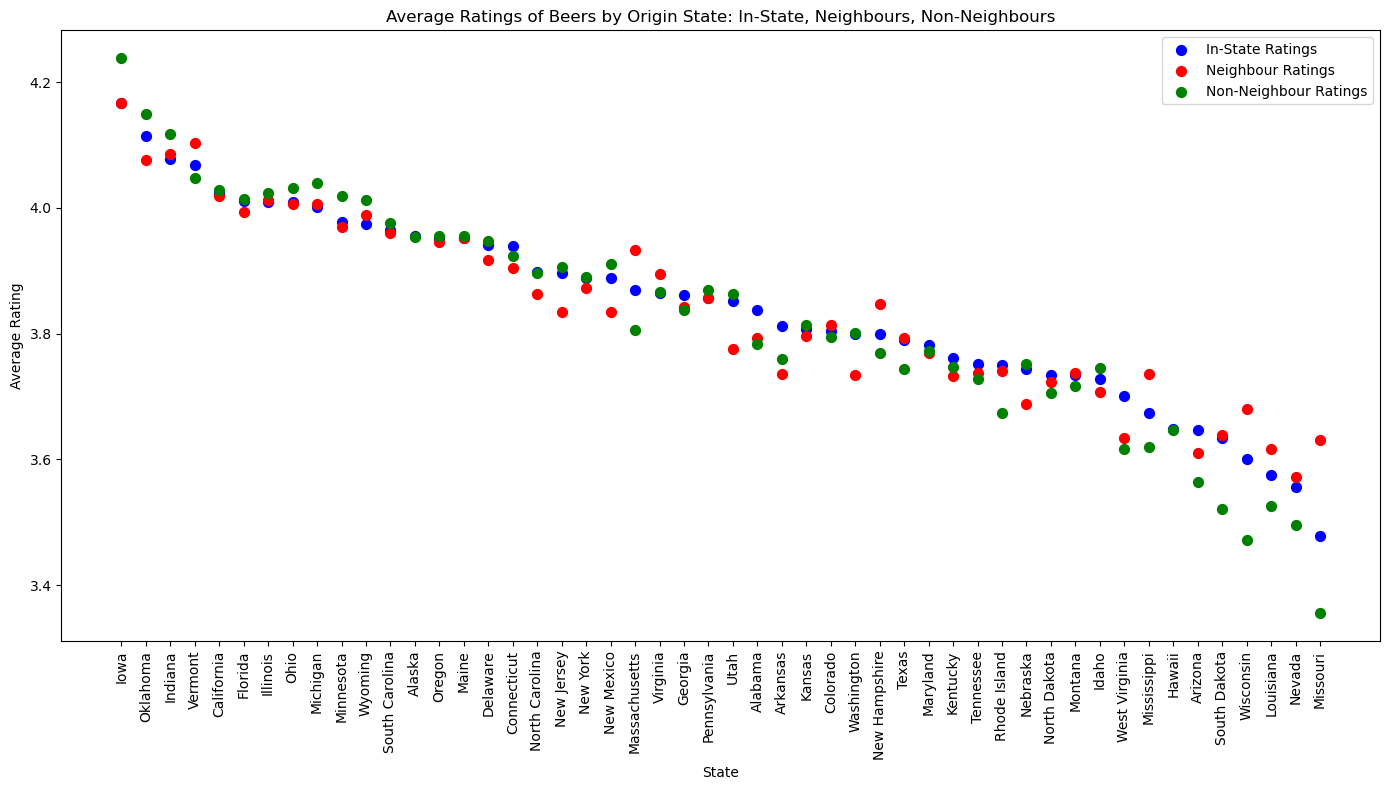

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the DataFrame by in_state_avg in descending order
ratings_df = ratings_df.sort_values(by='state_avg', ascending=False).reset_index(drop=True)

# Set figure size
plt.figure(figsize=(14, 8))

# Define the position of each state on the x-axis
index = np.arange(len(ratings_df))

# Plot dots for each rating category
plt.scatter(index, ratings_df['state_avg'], color='blue', label='In-State Ratings', s=50)
plt.scatter(index, ratings_df['neighbours_avg'], color='red', label='Neighbour Ratings', s=50)
plt.scatter(index, ratings_df['non_neighbours_avg'], color='green', label='Non-Neighbour Ratings', s=50)

# Add x-ticks and labels
plt.xticks(index, ratings_df['state'], rotation=90)
plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Average Ratings of Beers by Origin State: In-State, Neighbours, Non-Neighbours')
plt.legend()

# Layout adjustment for clarity
plt.tight_layout()

# Show plot
plt.show()


In [50]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               50 non-null     object 
 1   state_avg           50 non-null     float64
 2   neighbours_avg      48 non-null     float64
 3   non_neighbours_avg  50 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.7+ KB


In [51]:

custom_palette = {'In-State': 'blue', 'Out-State': 'orange'}

plt.figure(figsize=(12, 8))
sns.violinplot(
    x='state', 
    y='state_avg', 
    hue='state_IN_VS_OUT', 
    data=ratings_df, 
    palette=custom_palette, 
    split=True, 
    inner='quartile'
)

# Add plot details
plt.title("Violin Plot of Ratings by Beer State and In/Out-State Category")
plt.xlabel("Beer State")
plt.ylabel("Rating")
plt.xticks(rotation=90)
plt.legend(title="In vs Out of State")
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `state_IN_VS_OUT` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1200x800 with 0 Axes>

Analysis on whether the neighbouring states rate differently than non neighbours

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the count of ratings for each category
ratings_df['in_state_count'] = ratings_df['state'].apply(
    lambda state: US_ratings[(US_ratings['user_state'] == state) & (US_ratings['beer_state'] == state)].shape[0]
)
ratings_df['neighbours_count'] = ratings_df.apply(
    lambda row: US_ratings[(US_ratings['user_state'].isin(row['neighbours'])) & (US_ratings['beer_state'] == row['state'])].shape[0], axis=1
)
ratings_df['non_neighbours_count'] = ratings_df.apply(
    lambda row: US_ratings[(~US_ratings['user_state'].isin(row['neighbours'])) & 
                           (US_ratings['user_state'] != row['state']) &
                           (US_ratings['beer_state'] == row['state'])].shape[0], axis=1
)

# Sort by descending in_state_avg for better visualization
ratings_df = ratings_df.sort_values(by='state_avg', ascending=False).reset_index(drop=True)

# Set up the plot
plt.figure(figsize=(14, 8))
index = np.arange(len(ratings_df))

# Plot each group with size based on the count of ratings
plt.scatter(index, ratings_df['state_avg'], color='blue', s=ratings_df['in_state_count'] * 5, label='In-State Ratings')
plt.scatter(index, ratings_df['neighbours_avg'], color='red', s=ratings_df['neighbours_count'] * 5, label='Neighbour Ratings')
plt.scatter(index, ratings_df['non_neighbours_avg'], color='green', s=ratings_df['non_neighbours_count'] * 5, label='Non-Neighbour Ratings')

# Customize plot labels and legend
plt.xticks(index, ratings_df['state'], rotation=90)
plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Average Ratings of Beers by Origin State: In-State, Neighbours, Non-Neighbours')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


KeyError: 'neighbours'